In [1]:
%load_ext autoreload
%autoreload 2 


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import h5py
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from aux_functions import put_gaze_annotation, rgb,angle_to_2d,is_accurate, plot_metrics
from datasets import MPIIFaceGaze
from random import randint

# Tarea a resolver:

- Se desea predecir el ángulo de la mirada de un individuo a partir de una foto de su cara.
- Para eso se utilizará el dataset de MPIIFaceGaze. [Link aqui](https://www.mpi-inf.mpg.de/de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation).
    - El dataset consiste en imágenes de caras de 15 individuos distintos, mirando a diferentes lugares.
    - Se tienen 3000 imágenes por individuo con sus labels de pitch (ángulo vertical) y yaw (ángulo horizontal).
    - Las imágenes se tomaron de usuarios utilizando sus laptops durante 3 meses. 

# 0. Configuraciones

Configuraciones para CUDA

In [3]:
# Configuraciones para CUDA
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device a utilizar:",device)

Device a utilizar: cuda


# 1. Análisis de datos

En esta sección se analizan los siguientes aspectos del dataset:
1. Cantidad de imágenes y participantes
1.  Distribución de los ángulos de mirada en el dataset.

- El dataset se encuentra en un archivo con formato h5 localizado en la carpeta "datasets"

## 1.1. Cantidad de imágenes

In [5]:
with h5py.File('./datasets/MPIIFaceGaze.h5', 'r') as file:

    cant_imagenes = 0
    cant_imagenes_persona = []
    gaze_data = []

    for person_idx in range(len(file)):

        person = f"p{person_idx:02d}"
        dataset = file[person]

        images = dataset["image"]
        gaze = dataset["gaze"]
        pose = dataset["pose"]

        cant_imagenes += len(images)
        cant_imagenes_persona.append(len(images))

        # Almaceno todos los labels de miradas [pitch,yaw] del participante
        for i,g in enumerate(gaze):
            i_key = f"{i:04d}"
            gaze_data.append(np.array(gaze[i_key],dtype=float))

print(f"En el dataset hay: {cant_imagenes} imágenes de {len(cant_imagenes_persona)} personas.")
print(f"Las imágenes por persona son: {cant_imagenes_persona}")

/tmp/ipykernel_1605739/2887136188.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  gaze_data.append(np.array(gaze[i_key],dtype=float))


En el dataset hay: 45000 imágenes de 15 personas.
Las imágenes por persona son: [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]


Vemos que hay 3000 imágenes por cada persona y se tienen 15 sujetos diferentes. Veamos ahora la distribución de los ángulos de la mirada:

## 1.2. Distribución de ángulos de las miradas

En el dataset los ángulos de la mirada están representados por dos valores, pitch y yaw. Estos representan la rotación horizontal y vertical

En la siguiente imágen se ilustran los ángulos:

![head_ref.png](head_ref.png)

Se analizará la distribución entonces de:

- Pitch: Componente asociada al movimiento vertical.
- Yaw: Componente asociada al movimiento horizontal.
- Angle_2d: Proyección del ángulo en 2 dimensiones (para más información ver el archivo aux_functions.py)

In [6]:
gaze_array = np.array(gaze_data)
pitch_array = gaze_array[:,0]
yaw_array = gaze_array[:,1]
projected_2d_angle_array = angle_to_2d(gaze_array)

### 1.2.1 Pitch

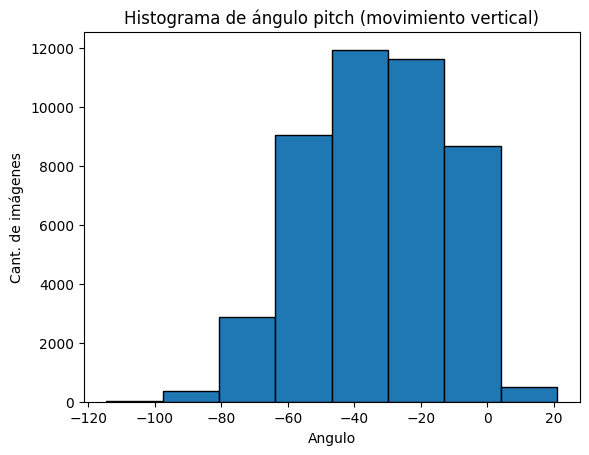

In [7]:
pitch_array_deg = np.rad2deg(pitch_array*np.pi)
plt.hist(pitch_array_deg, bins=8, edgecolor='black')
plt.xlabel('Angulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo pitch (movimiento vertical)')
plt.show()

### 1.2.2 Yaw

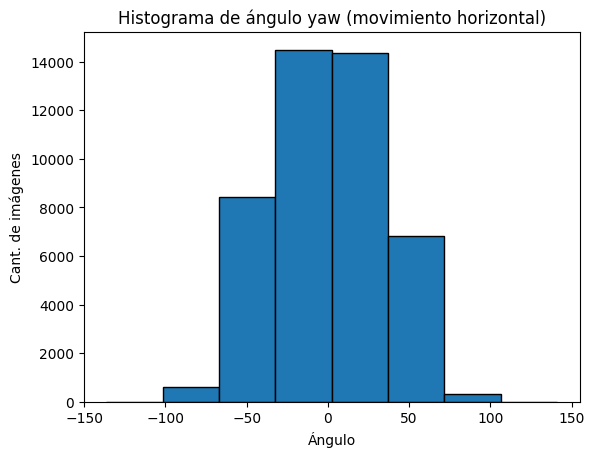

In [8]:
yaw_array_deg = np.rad2deg(yaw_array*np.pi)
plt.hist(yaw_array_deg, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo yaw (movimiento horizontal)')
plt.show()

### 1.2.3 Proyección de ángulos 2D

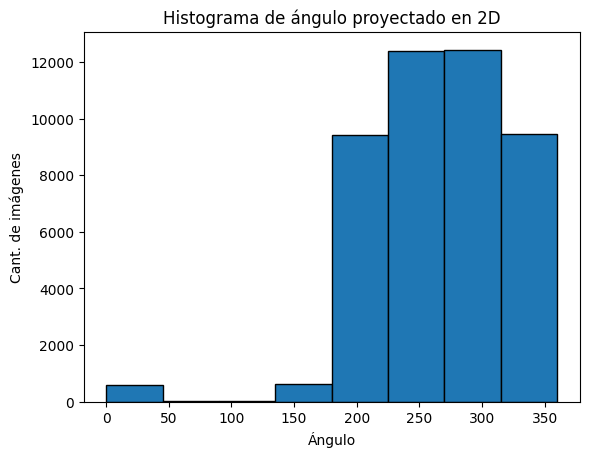

In [9]:
plt.hist(projected_2d_angle_array, bins=8, edgecolor='black')
plt.xlabel('Ángulo')
plt.ylabel('Cant. de imágenes')
plt.title('Histograma de ángulo proyectado en 2D')
plt.show()

### 1.2.4 Polar plot de pitch y yaw

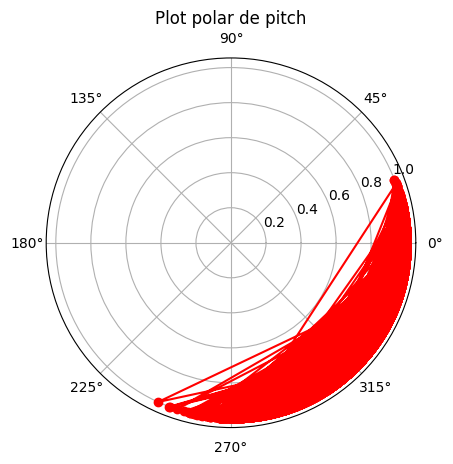

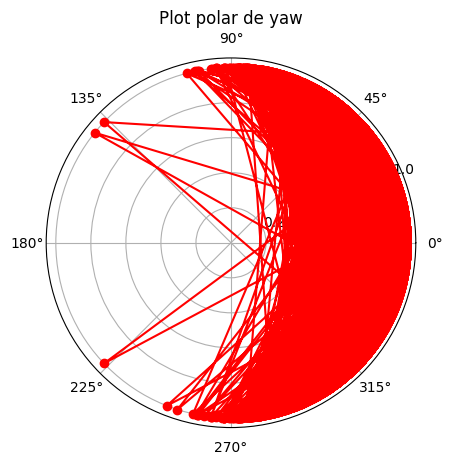

In [10]:
magnitude_array = np.ones_like(pitch_array)

# Pitch
plt.polar(pitch_array*np.pi, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de pitch')
# Show the plot
plt.show()

# Yaw
plt.polar(yaw_array*np.pi, magnitude_array, marker='o', linestyle='-', color='r')
plt.title('Plot polar de yaw')
# Show the plot
plt.show()

### 1.2.5 Distribución conjunta de pitch y yaw



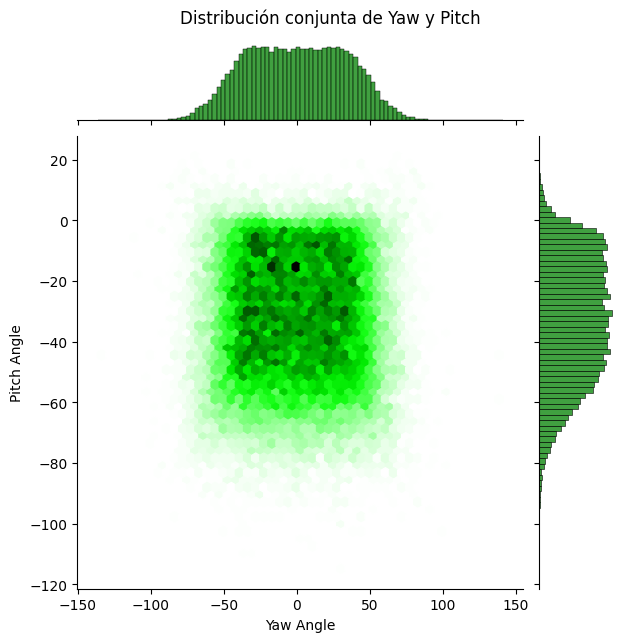

In [11]:
import seaborn as sns

sns.jointplot(x=yaw_array_deg, y=pitch_array_deg, kind="hex", color="g")
plt.xlabel('Yaw Angle')
plt.ylabel('Pitch Angle')
plt.suptitle('Distribución conjunta de Yaw y Pitch', y=1.03)
plt.show()

## 2. Preparación del dataset

- Para facilitar la carga de datos a pytorch se crea una clase que se hereda de torch.utils.Dataset. El código asociado se encuentra en el archivo _datasets.py_

In [12]:
from datasets import MPIIFaceGaze

In [13]:
# Selecciono pocas imágenes, solo para probar la que la clase funcione bien 
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", imgs_per_individual=3)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 45 imagenes


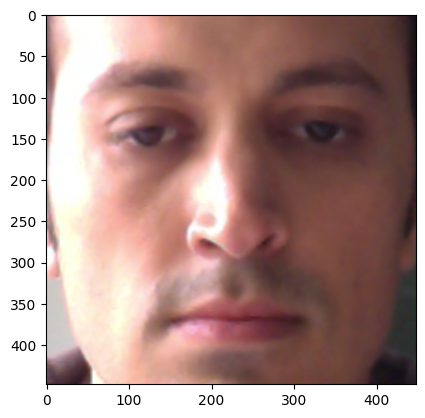

In [14]:
plt.imshow(ds.images_list[20][:,:,::-1])

## 2.1 Data augmentation

In [191]:
WIDTH = 224 
HEIGHT = 224

# Transformación de tamaño y data augmentation
data_transforms = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((WIDTH, HEIGHT)),
    # torchvision.transforms.RandomHorizontalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    # torchvision.transforms.RandomVerticalFlip(0.5), # No se puede usar aqui porque altera la dirección de la mirada
    torchvision.transforms.RandomResizedCrop(size=(WIDTH, HEIGHT), scale=(0.9, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.2, hue=0.05), # Pequeños cambios en hue para no alterar mucho los colores de la imagen
])


In [192]:
# Ahora sí cargamos todas las imágenes que se van a utilizar en el entrenamiento
ds = MPIIFaceGaze("./datasets/MPIIFaceGaze.h5", transform=data_transforms, imgs_per_individual=300)
print(f"Se cargaron {len(ds)} imagenes")

Dataset cargado correctamente de /home/idk/git/ceia/vpc2_project/datasets/MPIIFaceGaze.h5
Se cargaron 4500 imagenes


Ahora se separará el set en entrenamiento y testeo y luego se visualizarán las transformaciones

## 2.2 Creación de los set de entrenamiento y testeo

- Al usar resnet18 como capas previas (para aprovechar y hacer transfer learning), las imagenes deben ser redimensionadas a 224x224
- Data augmentation:
    - RandomResizedCrop: Se busca cortar y redimensionar la imagen aleatoreamente para generar más diversidad de datos
    - ColorJitter: Se realizan leves cambios en la saturación y el tono para garantizar más robustez ante distintas varaciones lumínicas y de color de ojos
    - No se pueden realizar transformaciones como HorizontalFlip o VerticalFlip porque alteran la posición de la mirada.

In [193]:
# Separo en entrenamiento y validacion (70% train, 30% test)
train_size = int(0.7*len(ds))  
test_size = len(ds)-train_size

train_dataset, test_dataset = random_split(ds, [train_size, test_size])

# Creo los dataloaders
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=48, shuffle=True)


torch.Size([48, 3, 224, 224]) torch.Size([48, 2])
pitch yaw: tensor([-0.2256,  0.2597], dtype=torch.float64)


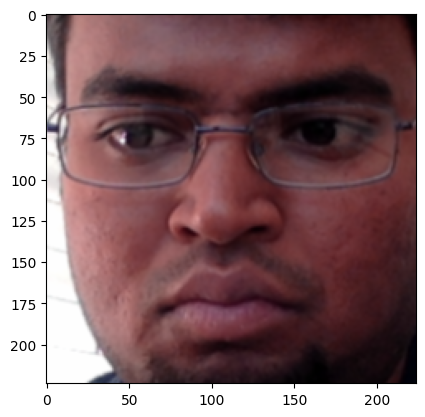

In [213]:
# Obtengo una imagen para visualizar las transformaciones
train_image, train_labels = next(iter(train_loader))

print(train_image.shape, train_labels.shape)

# Graficamos la imagen junto con el label para asegurarnos que esté bien cargada 
plt.imshow(train_image[0].permute(1, 2, 0).numpy()[:,:,::-1])
print(f'pitch yaw: {train_labels[0]}')

# 3. Modelos

Se probarán los siguientes modelos:

- Modelo _custom_: red neuronal hecha desde cero, con capas convolucionales y fully connected.

- Modelo basado en ResNet18:
    - Transfer Learning a partir de una ResNet 18.
    - Se congelan las primeras capas (para que no sean entrenables).
    - Se agregan 2 capas fully connected al final.

- Modelo basado en ResNet34:
    - Transfer Learning a partir de una ResNet 34.
    - Se congelan las primeras capas (para que no sean entrenables).
    - Se agregan 2 capas fully connected al final.

In [170]:
from models import GazeEstimation_ResNet18, GazeEstimation_ResNet34, CNN_custom
from torchsummary import summary


## 3.1 Red CNN propia

### 3.1.1 Instanciación

In [20]:
# Instanciación del modelo con una red CNN propia
model_cnn_propia = CNN_custom(name="cnn_propia__lr_dynamic__initk_3x3__less_dropoutd")
model_cnn_propia.dynamic_lr = True
model_cnn_propia.lr_adjustment_ratio = 0.3
model_cnn_propia.minimum_lr = 5e-5
model_cnn_propia.lr_epochs_adjustment = 20 # Cada 20 epochs se reduce el learning rate por un factor de 0.3

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_cnn_propia.parameters(), lr=1e-3)

#Summary
summary(model_cnn_propia.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
         Dropout2d-9           [-1, 32, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          18,496
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
        MaxPool2d-13           [-1, 64, 28, 28]               0
        Dropout2d-14           [-1, 64,

### 3.1.2. Entrenamiento

In [21]:
model_cnn_propia.fit(train_loader, val_loader, criterion, optimizer, epochs=90, device=device, save_model=True)

Epoch 1/90


Validation loss 86.48676: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


[Lr:0.001] Training Loss / Accuracy: 344.6915 / 7.39% | Validation Loss / Accuracy: 86.4868 / 0.62%
Epoch 2/90


Validation loss 3.25007: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 24.1014 / 8.77% | Validation Loss / Accuracy: 3.2501 / 0.00%
Epoch 3/90


Validation loss 0.40425: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 2.5248 / 6.33% | Validation Loss / Accuracy: 0.4042 / 14.44%
Epoch 4/90


Validation loss 0.14391: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.3962 / 11.65% | Validation Loss / Accuracy: 0.1439 / 17.57%
Epoch 5/90


Validation loss 0.07229: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.1600 / 13.34% | Validation Loss / Accuracy: 0.0723 / 14.72%
Epoch 6/90


Validation loss 0.05327: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.1368 / 13.12% | Validation Loss / Accuracy: 0.0533 / 18.33%
Epoch 7/90


Validation loss 0.05740: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


[Lr:0.001] Training Loss / Accuracy: 0.1094 / 14.35% | Validation Loss / Accuracy: 0.0574 / 19.31%
Epoch 8/90


Validation loss 0.05951: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0927 / 14.56% | Validation Loss / Accuracy: 0.0595 / 16.32%
Epoch 9/90


Validation loss 0.04568: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.0879 / 14.00% | Validation Loss / Accuracy: 0.0457 / 19.03%
Epoch 10/90


Validation loss 0.05555: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0815 / 16.65% | Validation Loss / Accuracy: 0.0556 / 15.21%
Epoch 11/90


Validation loss 0.05139: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0741 / 16.48% | Validation Loss / Accuracy: 0.0514 / 19.10%
Epoch 12/90


Validation loss 0.04426: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.0643 / 15.96% | Validation Loss / Accuracy: 0.0443 / 17.57%
Epoch 13/90


Validation loss 0.04219: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.0597 / 17.22% | Validation Loss / Accuracy: 0.0422 / 17.57%
Epoch 14/90


Validation loss 0.03667: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.0544 / 15.72% | Validation Loss / Accuracy: 0.0367 / 20.00%
Epoch 15/90


Validation loss 0.03719: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0515 / 15.99% | Validation Loss / Accuracy: 0.0372 / 20.69%
Epoch 16/90


Validation loss 0.03581: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.0489 / 15.96% | Validation Loss / Accuracy: 0.0358 / 17.08%
Epoch 17/90


Validation loss 0.03726: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0439 / 17.18% | Validation Loss / Accuracy: 0.0373 / 18.12%
Epoch 18/90


Validation loss 0.03765: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:0.001] Training Loss / Accuracy: 0.0450 / 17.21% | Validation Loss / Accuracy: 0.0377 / 16.94%
Epoch 19/90


Validation loss 0.03568: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.001] Training Loss / Accuracy: 0.0399 / 19.18% | Validation Loss / Accuracy: 0.0357 / 20.21%
Epoch 20/90


Validation loss 0.03394: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0379 / 18.99% | Validation Loss / Accuracy: 0.0339 / 17.50%
Epoch 21/90


Validation loss 0.03382: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0354 / 16.52% | Validation Loss / Accuracy: 0.0338 / 19.31%
Epoch 22/90


Validation loss 0.03375: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0379 / 18.82% | Validation Loss / Accuracy: 0.0338 / 16.46%
Epoch 23/90


Validation loss 0.03367: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0370 / 17.80% | Validation Loss / Accuracy: 0.0337 / 17.64%
Epoch 24/90


Validation loss 0.03080: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0363 / 17.19% | Validation Loss / Accuracy: 0.0308 / 17.71%
Epoch 25/90


Validation loss 0.03080: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0341 / 18.33% | Validation Loss / Accuracy: 0.0308 / 18.47%
Epoch 26/90


Validation loss 0.03027: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0350 / 17.90% | Validation Loss / Accuracy: 0.0303 / 15.90%
Epoch 27/90


Validation loss 0.03171: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0350 / 18.26% | Validation Loss / Accuracy: 0.0317 / 18.61%
Epoch 28/90


Validation loss 0.03202: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0371 / 17.69% | Validation Loss / Accuracy: 0.0320 / 17.99%
Epoch 29/90


Validation loss 0.03099: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0347 / 18.24% | Validation Loss / Accuracy: 0.0310 / 16.87%
Epoch 30/90


Validation loss 0.03141: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0331 / 17.78% | Validation Loss / Accuracy: 0.0314 / 14.86%
Epoch 31/90


Validation loss 0.03176: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0321 / 21.20% | Validation Loss / Accuracy: 0.0318 / 17.85%
Epoch 32/90


Validation loss 0.03213: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0315 / 19.17% | Validation Loss / Accuracy: 0.0321 / 18.82%
Epoch 33/90


Validation loss 0.02966: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0333 / 17.56% | Validation Loss / Accuracy: 0.0297 / 20.28%
Epoch 34/90


Validation loss 0.03056: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0328 / 20.63% | Validation Loss / Accuracy: 0.0306 / 17.92%
Epoch 35/90


Validation loss 0.03139: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0338 / 16.48% | Validation Loss / Accuracy: 0.0314 / 17.99%
Epoch 36/90


Validation loss 0.03037: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0335 / 18.28% | Validation Loss / Accuracy: 0.0304 / 17.08%
Epoch 37/90


Validation loss 0.02873: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0316 / 20.05% | Validation Loss / Accuracy: 0.0287 / 17.92%
Epoch 38/90


Validation loss 0.02866: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:0.0003] Training Loss / Accuracy: 0.0307 / 18.11% | Validation Loss / Accuracy: 0.0287 / 19.86%
Epoch 39/90


Validation loss 0.03020: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


[Lr:0.0003] Training Loss / Accuracy: 0.0295 / 20.87% | Validation Loss / Accuracy: 0.0302 / 18.19%
Epoch 40/90


Validation loss 0.02874: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0313 / 18.02% | Validation Loss / Accuracy: 0.0287 / 17.71%
Epoch 41/90


Validation loss 0.02824: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0309 / 18.28% | Validation Loss / Accuracy: 0.0282 / 18.40%
Epoch 42/90


Validation loss 0.02729: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0301 / 19.33% | Validation Loss / Accuracy: 0.0273 / 19.79%
Epoch 43/90


Validation loss 0.02828: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0301 / 19.35% | Validation Loss / Accuracy: 0.0283 / 20.42%
Epoch 44/90


Validation loss 0.02827: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0302 / 18.66% | Validation Loss / Accuracy: 0.0283 / 20.90%
Epoch 45/90


Validation loss 0.02809: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0299 / 19.01% | Validation Loss / Accuracy: 0.0281 / 19.38%
Epoch 46/90


Validation loss 0.02859: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0309 / 18.22% | Validation Loss / Accuracy: 0.0286 / 20.56%
Epoch 47/90


Validation loss 0.02799: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0308 / 20.09% | Validation Loss / Accuracy: 0.0280 / 18.33%
Epoch 48/90


Validation loss 0.02959: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0298 / 19.79% | Validation Loss / Accuracy: 0.0296 / 17.85%
Epoch 49/90


Validation loss 0.02922: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0294 / 17.94% | Validation Loss / Accuracy: 0.0292 / 17.71%
Epoch 50/90


Validation loss 0.02734: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0292 / 17.59% | Validation Loss / Accuracy: 0.0273 / 19.86%
Epoch 51/90


Validation loss 0.03076: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0296 / 19.81% | Validation Loss / Accuracy: 0.0308 / 18.33%
Epoch 52/90


Validation loss 0.02831: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0291 / 19.97% | Validation Loss / Accuracy: 0.0283 / 19.51%
Epoch 53/90


Validation loss 0.02817: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0293 / 19.07% | Validation Loss / Accuracy: 0.0282 / 20.83%
Epoch 54/90


Validation loss 0.03101: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0309 / 18.17% | Validation Loss / Accuracy: 0.0310 / 16.74%
Epoch 55/90


Validation loss 0.02861: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0294 / 19.05% | Validation Loss / Accuracy: 0.0286 / 18.75%
Epoch 56/90


Validation loss 0.02691: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0295 / 17.79% | Validation Loss / Accuracy: 0.0269 / 17.85%
Epoch 57/90


Validation loss 0.02945: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0306 / 18.29% | Validation Loss / Accuracy: 0.0294 / 20.56%
Epoch 58/90


Validation loss 0.02856: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0291 / 20.12% | Validation Loss / Accuracy: 0.0286 / 22.01%
Epoch 59/90


Validation loss 0.02904: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


[Lr:8.999999999999999e-05] Training Loss / Accuracy: 0.0280 / 19.99% | Validation Loss / Accuracy: 0.0290 / 19.17%
Epoch 60/90


Validation loss 0.02740: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0277 / 19.71% | Validation Loss / Accuracy: 0.0274 / 18.68%
Epoch 61/90


Validation loss 0.02769: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0297 / 18.67% | Validation Loss / Accuracy: 0.0277 / 24.38%
Epoch 62/90


Validation loss 0.02700: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0287 / 18.48% | Validation Loss / Accuracy: 0.0270 / 17.99%
Epoch 63/90


Validation loss 0.02730: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0289 / 16.52% | Validation Loss / Accuracy: 0.0273 / 20.76%
Epoch 64/90


Validation loss 0.02863: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0291 / 19.44% | Validation Loss / Accuracy: 0.0286 / 18.54%
Epoch 65/90


Validation loss 0.02761: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0283 / 22.08% | Validation Loss / Accuracy: 0.0276 / 19.86%
Epoch 66/90


Validation loss 0.02899: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0290 / 20.73% | Validation Loss / Accuracy: 0.0290 / 17.85%
Epoch 67/90


Validation loss 0.02738: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0280 / 17.22% | Validation Loss / Accuracy: 0.0274 / 20.56%
Epoch 68/90


Validation loss 0.02843: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0290 / 16.45% | Validation Loss / Accuracy: 0.0284 / 19.79%
Epoch 69/90


Validation loss 0.02756: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0290 / 18.93% | Validation Loss / Accuracy: 0.0276 / 20.49%
Epoch 70/90


Validation loss 0.02879: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0298 / 19.22% | Validation Loss / Accuracy: 0.0288 / 16.32%
Epoch 71/90


Validation loss 0.02889: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0270 / 19.37% | Validation Loss / Accuracy: 0.0289 / 17.36%
Epoch 72/90


Validation loss 0.02723: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0286 / 19.37% | Validation Loss / Accuracy: 0.0272 / 21.39%
Epoch 73/90


Validation loss 0.02770: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0280 / 19.86% | Validation Loss / Accuracy: 0.0277 / 16.53%
Epoch 74/90


Validation loss 0.02969: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0279 / 20.90% | Validation Loss / Accuracy: 0.0297 / 20.28%
Epoch 75/90


Validation loss 0.02761: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0292 / 18.28% | Validation Loss / Accuracy: 0.0276 / 18.82%
Epoch 76/90


Validation loss 0.02630: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0287 / 20.09% | Validation Loss / Accuracy: 0.0263 / 19.58%
Epoch 77/90


Validation loss 0.02823: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0281 / 17.15% | Validation Loss / Accuracy: 0.0282 / 18.96%
Epoch 78/90


Validation loss 0.02699: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0276 / 18.67% | Validation Loss / Accuracy: 0.0270 / 22.78%
Epoch 79/90


Validation loss 0.02781: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0286 / 18.29% | Validation Loss / Accuracy: 0.0278 / 21.81%
Epoch 80/90


Validation loss 0.02726: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0280 / 20.79% | Validation Loss / Accuracy: 0.0273 / 21.39%
Epoch 81/90


Validation loss 0.02650: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0288 / 17.91% | Validation Loss / Accuracy: 0.0265 / 21.04%
Epoch 82/90


Validation loss 0.02784: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0282 / 20.39% | Validation Loss / Accuracy: 0.0278 / 22.78%
Epoch 83/90


Validation loss 0.02953: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0286 / 18.26% | Validation Loss / Accuracy: 0.0295 / 20.69%
Epoch 84/90


Validation loss 0.02728: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0287 / 19.40% | Validation Loss / Accuracy: 0.0273 / 20.28%
Epoch 85/90


Validation loss 0.02727: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0281 / 17.32% | Validation Loss / Accuracy: 0.0273 / 17.78%
Epoch 86/90


Validation loss 0.02776: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0279 / 19.03% | Validation Loss / Accuracy: 0.0278 / 21.39%
Epoch 87/90


Validation loss 0.02697: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0281 / 20.77% | Validation Loss / Accuracy: 0.0270 / 20.35%
Epoch 88/90


Validation loss 0.02899: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0292 / 19.20% | Validation Loss / Accuracy: 0.0290 / 20.97%
Epoch 89/90


Validation loss 0.02705: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


[Lr:5e-05] Training Loss / Accuracy: 0.0283 / 20.28% | Validation Loss / Accuracy: 0.0270 / 19.65%
Epoch 90/90


Validation loss 0.02579: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth
[Lr:5e-05] Training Loss / Accuracy: 0.0283 / 19.97% | Validation Loss / Accuracy: 0.0258 / 21.53%


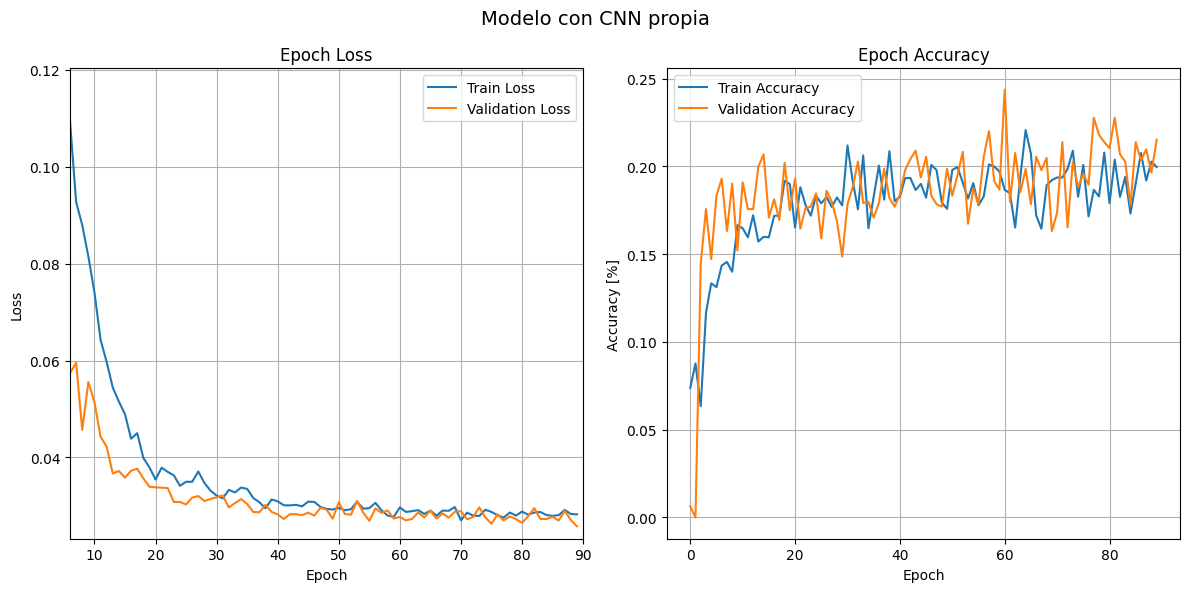

In [22]:
plot_metrics(model_cnn_propia,title="Modelo con CNN propia")

## 3.2 Red basada en ResNet18

### 3.2.1. Instanciación

In [217]:
# Instanciación del modelo con resnet18
model_resnet18 = GazeEstimation_ResNet18(name="resnet18_individual_fc_dropout",pretrained=True) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet18.dynamic_lr = False
model_resnet18.lr_epochs_adjustment = 30 # Cada 30 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-5)

#Summary
summary(model_resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 3.2.2. Entrenamiento

In [218]:
model_resnet18.fit(train_loader, val_loader, criterion, optimizer, epochs=90, device=device, save_model=True)

Epoch 1/90


Validation loss 0.26815: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.6601 / 2.51% | Validation Loss / Accuracy: 0.2681 / 0.57%
Epoch 2/90


Validation loss 0.13433: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.3426 / 4.61% | Validation Loss / Accuracy: 0.1343 / 3.74%
Epoch 3/90


Validation loss 0.06232: 100%|██████████| 29/29 [00:39<00:00,  1.38s/it]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.2269 / 8.19% | Validation Loss / Accuracy: 0.0623 / 15.37%
Epoch 4/90


Validation loss 0.05669: 100%|██████████| 29/29 [00:22<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1852 / 11.10% | Validation Loss / Accuracy: 0.0567 / 16.45%
Epoch 5/90


Validation loss 0.04682: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1771 / 12.00% | Validation Loss / Accuracy: 0.0468 / 18.97%
Epoch 6/90


Validation loss 0.04427: 100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1739 / 12.22% | Validation Loss / Accuracy: 0.0443 / 18.89%
Epoch 7/90


Validation loss 0.04006: 100%|██████████| 29/29 [00:22<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1711 / 13.90% | Validation Loss / Accuracy: 0.0401 / 20.26%
Epoch 8/90


Validation loss 0.03718: 100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1619 / 13.08% | Validation Loss / Accuracy: 0.0372 / 21.26%
Epoch 9/90


Validation loss 0.03668: 100%|██████████| 29/29 [00:22<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1554 / 13.79% | Validation Loss / Accuracy: 0.0367 / 21.41%
Epoch 10/90


Validation loss 0.03448: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1531 / 13.77% | Validation Loss / Accuracy: 0.0345 / 22.41%
Epoch 11/90


Validation loss 0.03115: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1494 / 12.75% | Validation Loss / Accuracy: 0.0311 / 23.71%
Epoch 12/90


Validation loss 0.03077: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1383 / 14.36% | Validation Loss / Accuracy: 0.0308 / 21.70%
Epoch 13/90


Validation loss 0.03062: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1386 / 14.24% | Validation Loss / Accuracy: 0.0306 / 20.62%
Epoch 14/90


Validation loss 0.02732: 100%|██████████| 29/29 [00:23<00:00,  1.24it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1359 / 14.92% | Validation Loss / Accuracy: 0.0273 / 25.93%
Epoch 15/90


Validation loss 0.02839: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.1325 / 13.02% | Validation Loss / Accuracy: 0.0284 / 25.07%
Epoch 16/90


Validation loss 0.02510: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1249 / 15.27% | Validation Loss / Accuracy: 0.0251 / 25.86%
Epoch 17/90


Validation loss 0.02507: 100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1247 / 14.64% | Validation Loss / Accuracy: 0.0251 / 28.09%
Epoch 18/90


Validation loss 0.02428: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1175 / 15.20% | Validation Loss / Accuracy: 0.0243 / 25.65%
Epoch 19/90


Validation loss 0.02242: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1139 / 15.39% | Validation Loss / Accuracy: 0.0224 / 27.73%
Epoch 20/90


Validation loss 0.02140: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.1116 / 14.32% | Validation Loss / Accuracy: 0.0214 / 26.80%
Epoch 21/90


Validation loss 0.02168: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.1030 / 15.86% | Validation Loss / Accuracy: 0.0217 / 26.01%
Epoch 22/90


Validation loss 0.02157: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.1011 / 14.99% | Validation Loss / Accuracy: 0.0216 / 27.59%
Epoch 23/90


Validation loss 0.02010: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0903 / 15.74% | Validation Loss / Accuracy: 0.0201 / 27.23%
Epoch 24/90


Validation loss 0.01884: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0885 / 16.33% | Validation Loss / Accuracy: 0.0188 / 27.01%
Epoch 25/90


Validation loss 0.01827: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0856 / 15.54% | Validation Loss / Accuracy: 0.0183 / 29.53%
Epoch 26/90


Validation loss 0.01930: 100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0812 / 16.48% | Validation Loss / Accuracy: 0.0193 / 28.16%
Epoch 27/90


Validation loss 0.01730: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0767 / 16.84% | Validation Loss / Accuracy: 0.0173 / 29.53%
Epoch 28/90


Validation loss 0.01766: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0733 / 15.73% | Validation Loss / Accuracy: 0.0177 / 29.53%
Epoch 29/90


Validation loss 0.01690: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0740 / 16.27% | Validation Loss / Accuracy: 0.0169 / 29.81%
Epoch 30/90


Validation loss 0.01747: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0680 / 16.70% | Validation Loss / Accuracy: 0.0175 / 29.24%
Epoch 31/90


Validation loss 0.01619: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0667 / 17.22% | Validation Loss / Accuracy: 0.0162 / 30.32%
Epoch 32/90


Validation loss 0.01591: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0637 / 17.54% | Validation Loss / Accuracy: 0.0159 / 33.55%
Epoch 33/90


Validation loss 0.01662: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0628 / 18.27% | Validation Loss / Accuracy: 0.0166 / 30.68%
Epoch 34/90


Validation loss 0.01451: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0597 / 19.12% | Validation Loss / Accuracy: 0.0145 / 34.12%
Epoch 35/90


Validation loss 0.01483: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0575 / 17.90% | Validation Loss / Accuracy: 0.0148 / 31.61%
Epoch 36/90


Validation loss 0.01432: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0571 / 19.40% | Validation Loss / Accuracy: 0.0143 / 31.68%
Epoch 37/90


Validation loss 0.01432: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0541 / 19.39% | Validation Loss / Accuracy: 0.0143 / 32.97%
Epoch 38/90


Validation loss 0.01378: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0530 / 19.53% | Validation Loss / Accuracy: 0.0138 / 36.42%
Epoch 39/90


Validation loss 0.01323: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0495 / 20.28% | Validation Loss / Accuracy: 0.0132 / 37.50%
Epoch 40/90


Validation loss 0.01434: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0502 / 19.75% | Validation Loss / Accuracy: 0.0143 / 36.28%
Epoch 41/90


Validation loss 0.01228: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0494 / 20.21% | Validation Loss / Accuracy: 0.0123 / 40.73%
Epoch 42/90


Validation loss 0.01194: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0473 / 21.97% | Validation Loss / Accuracy: 0.0119 / 39.66%
Epoch 43/90


Validation loss 0.01180: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0453 / 22.40% | Validation Loss / Accuracy: 0.0118 / 41.88%
Epoch 44/90


Validation loss 0.01107: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0433 / 21.57% | Validation Loss / Accuracy: 0.0111 / 42.74%
Epoch 45/90


Validation loss 0.01118: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0434 / 23.73% | Validation Loss / Accuracy: 0.0112 / 39.30%
Epoch 46/90


Validation loss 0.01110: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0400 / 23.92% | Validation Loss / Accuracy: 0.0111 / 42.24%
Epoch 47/90


Validation loss 0.01059: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0411 / 22.57% | Validation Loss / Accuracy: 0.0106 / 42.96%
Epoch 48/90


Validation loss 0.01165: 100%|██████████| 29/29 [00:22<00:00,  1.32it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0389 / 23.71% | Validation Loss / Accuracy: 0.0116 / 43.25%
Epoch 49/90


Validation loss 0.01037: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0380 / 24.75% | Validation Loss / Accuracy: 0.0104 / 45.33%
Epoch 50/90


Validation loss 0.01091: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0369 / 24.61% | Validation Loss / Accuracy: 0.0109 / 41.52%
Epoch 51/90


Validation loss 0.01082: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0380 / 25.11% | Validation Loss / Accuracy: 0.0108 / 45.19%
Epoch 52/90


Validation loss 0.00995: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0354 / 24.60% | Validation Loss / Accuracy: 0.0100 / 42.82%
Epoch 53/90


Validation loss 0.00987: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0363 / 26.26% | Validation Loss / Accuracy: 0.0099 / 46.91%
Epoch 54/90


Validation loss 0.00956: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0355 / 25.89% | Validation Loss / Accuracy: 0.0096 / 47.70%
Epoch 55/90


Validation loss 0.00950: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0341 / 26.01% | Validation Loss / Accuracy: 0.0095 / 46.26%
Epoch 56/90


Validation loss 0.00965: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0333 / 26.89% | Validation Loss / Accuracy: 0.0097 / 45.19%
Epoch 57/90


Validation loss 0.00882: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0323 / 25.84% | Validation Loss / Accuracy: 0.0088 / 46.70%
Epoch 58/90


Validation loss 0.00941: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0320 / 27.59% | Validation Loss / Accuracy: 0.0094 / 43.61%
Epoch 59/90


Validation loss 0.00888: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0310 / 27.70% | Validation Loss / Accuracy: 0.0089 / 49.64%
Epoch 60/90


Validation loss 0.00873: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0306 / 26.93% | Validation Loss / Accuracy: 0.0087 / 53.45%
Epoch 61/90


Validation loss 0.00831: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0290 / 28.13% | Validation Loss / Accuracy: 0.0083 / 48.13%
Epoch 62/90


Validation loss 0.00910: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0292 / 27.68% | Validation Loss / Accuracy: 0.0091 / 48.20%
Epoch 63/90


Validation loss 0.00779: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0286 / 27.83% | Validation Loss / Accuracy: 0.0078 / 51.65%
Epoch 64/90


Validation loss 0.00772: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0281 / 29.51% | Validation Loss / Accuracy: 0.0077 / 51.29%
Epoch 65/90


Validation loss 0.00755: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0273 / 30.28% | Validation Loss / Accuracy: 0.0075 / 56.25%
Epoch 66/90


Validation loss 0.00766: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0271 / 29.89% | Validation Loss / Accuracy: 0.0077 / 53.16%
Epoch 67/90


Validation loss 0.00794: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0266 / 31.07% | Validation Loss / Accuracy: 0.0079 / 51.51%
Epoch 68/90


Validation loss 0.00729: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0252 / 30.71% | Validation Loss / Accuracy: 0.0073 / 54.31%
Epoch 69/90


Validation loss 0.00753: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0251 / 31.52% | Validation Loss / Accuracy: 0.0075 / 55.68%
Epoch 70/90


Validation loss 0.00747: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0254 / 30.21% | Validation Loss / Accuracy: 0.0075 / 55.10%
Epoch 71/90


Validation loss 0.00664: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0242 / 31.00% | Validation Loss / Accuracy: 0.0066 / 56.47%
Epoch 72/90


Validation loss 0.00716: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0246 / 32.18% | Validation Loss / Accuracy: 0.0072 / 56.75%
Epoch 73/90


Validation loss 0.00713: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0237 / 33.07% | Validation Loss / Accuracy: 0.0071 / 57.26%
Epoch 74/90


Validation loss 0.00639: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0233 / 32.48% | Validation Loss / Accuracy: 0.0064 / 56.25%
Epoch 75/90


Validation loss 0.00652: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0228 / 33.03% | Validation Loss / Accuracy: 0.0065 / 59.77%
Epoch 76/90


Validation loss 0.00658: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0221 / 34.24% | Validation Loss / Accuracy: 0.0066 / 57.97%
Epoch 77/90


Validation loss 0.00653: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0229 / 33.50% | Validation Loss / Accuracy: 0.0065 / 55.24%
Epoch 78/90


Validation loss 0.00621: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0220 / 31.82% | Validation Loss / Accuracy: 0.0062 / 61.64%
Epoch 79/90


Validation loss 0.00634: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0213 / 33.74% | Validation Loss / Accuracy: 0.0063 / 56.68%
Epoch 80/90


Validation loss 0.00607: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0209 / 33.86% | Validation Loss / Accuracy: 0.0061 / 59.77%
Epoch 81/90


Validation loss 0.00642: 100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0208 / 34.29% | Validation Loss / Accuracy: 0.0064 / 57.33%
Epoch 82/90


Validation loss 0.00618: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0209 / 34.80% | Validation Loss / Accuracy: 0.0062 / 59.63%
Epoch 83/90


Validation loss 0.00563: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0201 / 34.63% | Validation Loss / Accuracy: 0.0056 / 60.99%
Epoch 84/90


Validation loss 0.00570: 100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0200 / 36.59% | Validation Loss / Accuracy: 0.0057 / 62.50%
Epoch 85/90


Validation loss 0.00554: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0188 / 35.03% | Validation Loss / Accuracy: 0.0055 / 63.65%
Epoch 86/90


Validation loss 0.00554: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0184 / 36.36% | Validation Loss / Accuracy: 0.0055 / 60.63%
Epoch 87/90


Validation loss 0.00540: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0191 / 34.99% | Validation Loss / Accuracy: 0.0054 / 63.65%
Epoch 88/90


Validation loss 0.00543: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0178 / 36.81% | Validation Loss / Accuracy: 0.0054 / 61.35%
Epoch 89/90


Validation loss 0.00525: 100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet18_individual_fc_dropout.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0180 / 35.85% | Validation Loss / Accuracy: 0.0052 / 62.57%
Epoch 90/90


Validation loss 0.00526: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]

[Lr:1e-05] Training Loss / Accuracy: 0.0176 / 37.30% | Validation Loss / Accuracy: 0.0053 / 62.14%


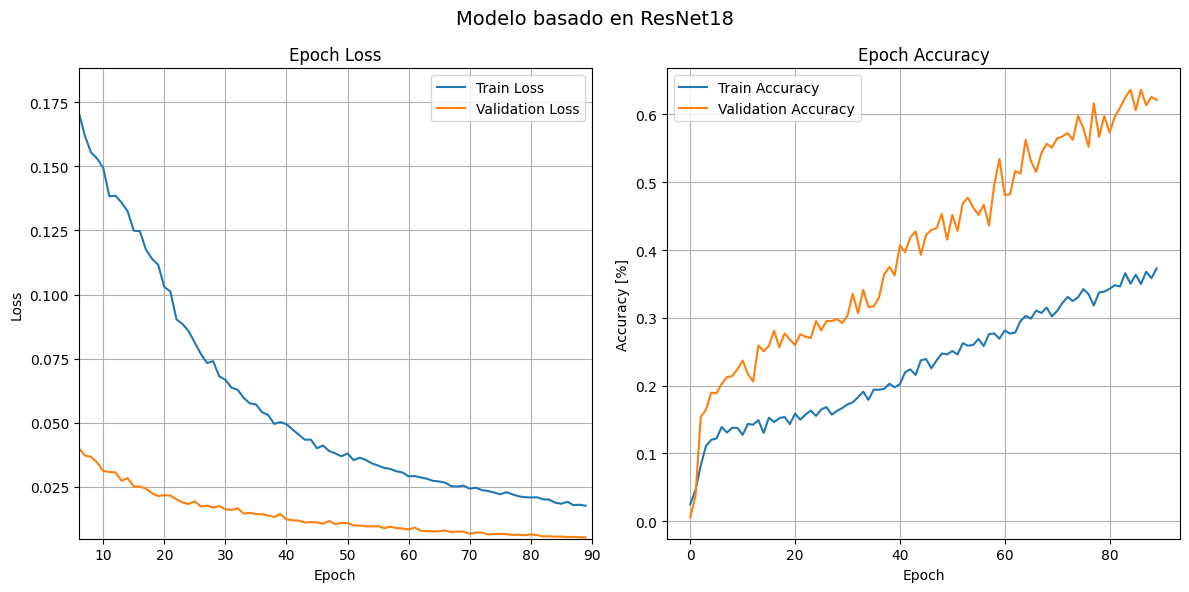

In [220]:
plot_metrics(model_resnet18,title="Modelo basado en ResNet18")

In [26]:
# Para probar que se haya guardado bien el mejor modelo entrenado
# new_model = GazeEstimation_ResNet18()
# new_model.load_state_dict(torch.load('./modelos/resnet18.pth'))
# new_model.to(device)

# inputs = torch.randn(8, 3, 224, 224).to(device) 
# outputs = new_model(inputs) 

# print(outputs)

## 3.3 Modelo basado en ResNet34

### 3.3.1 Instanciación

In [27]:
# Instanciación del modelo con resnet34
model_resnet34 = GazeEstimation_ResNet34(name="resnet34_no_freezed",pretrained=True,debug=False) #Debug en True para ver qué capas son entrenables y cuáles no
model_resnet34.dynamic_lr = True
model_resnet34.minimum_lr = 1e-7
model_resnet34.lr_epochs_adjustment = 60 # Cada 60 epochs se reduce el learning rate por un factor de 0.1

# Al ser un problema de regresión se usa MSELoss
criterion = nn.MSELoss()

# Optimizador: Adam
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-5)

#Summary
summary(model_resnet34.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 3.3.2 Entrenamiento

In [28]:
model_resnet34.fit(train_loader, val_loader, criterion, optimizer, epochs=150, device=device, save_model=True)

Epoch 1/150


Validation loss 0.06754: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0745 / 0.57% | Validation Loss / Accuracy: 0.0675 / 0.21%
Epoch 2/150


Validation loss 0.07042: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0740 / 0.76% | Validation Loss / Accuracy: 0.0704 / 0.00%
Epoch 3/150


Validation loss 0.06923: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0737 / 0.66% | Validation Loss / Accuracy: 0.0692 / 0.21%
Epoch 4/150


Validation loss 0.07046: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0748 / 0.85% | Validation Loss / Accuracy: 0.0705 / 0.42%
Epoch 5/150


Validation loss 0.06989: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0740 / 0.47% | Validation Loss / Accuracy: 0.0699 / 0.21%
Epoch 6/150


Validation loss 0.06971: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0726 / 0.66% | Validation Loss / Accuracy: 0.0697 / 0.42%
Epoch 7/150


Validation loss 0.07019: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0750 / 0.49% | Validation Loss / Accuracy: 0.0702 / 0.00%
Epoch 8/150


Validation loss 0.07165: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0745 / 0.76% | Validation Loss / Accuracy: 0.0717 / 0.00%
Epoch 9/150


Validation loss 0.06962: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0736 / 0.77% | Validation Loss / Accuracy: 0.0696 / 0.21%
Epoch 10/150


Validation loss 0.07150: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0746 / 1.04% | Validation Loss / Accuracy: 0.0715 / 0.42%
Epoch 11/150


Validation loss 0.07061: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0741 / 0.66% | Validation Loss / Accuracy: 0.0706 / 0.00%
Epoch 12/150


Validation loss 0.06997: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0737 / 1.34% | Validation Loss / Accuracy: 0.0700 / 0.42%
Epoch 13/150


Validation loss 0.06882: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0752 / 0.38% | Validation Loss / Accuracy: 0.0688 / 0.97%
Epoch 14/150


Validation loss 0.06871: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0756 / 0.58% | Validation Loss / Accuracy: 0.0687 / 0.76%
Epoch 15/150


Validation loss 0.06878: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0739 / 0.85% | Validation Loss / Accuracy: 0.0688 / 0.21%
Epoch 16/150


Validation loss 0.07094: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0737 / 0.09% | Validation Loss / Accuracy: 0.0709 / 0.83%
Epoch 17/150


Validation loss 0.07073: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0743 / 0.78% | Validation Loss / Accuracy: 0.0707 / 0.00%
Epoch 18/150


Validation loss 0.07007: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0751 / 0.85% | Validation Loss / Accuracy: 0.0701 / 0.21%
Epoch 19/150


Validation loss 0.06977: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0737 / 1.33% | Validation Loss / Accuracy: 0.0698 / 0.00%
Epoch 20/150


Validation loss 0.06856: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0744 / 0.66% | Validation Loss / Accuracy: 0.0686 / 0.00%
Epoch 21/150


Validation loss 0.07015: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0746 / 1.15% | Validation Loss / Accuracy: 0.0701 / 0.42%
Epoch 22/150


Validation loss 0.07116: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0730 / 0.57% | Validation Loss / Accuracy: 0.0712 / 0.62%
Epoch 23/150


Validation loss 0.07033: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0737 / 0.66% | Validation Loss / Accuracy: 0.0703 / 0.62%
Epoch 24/150


Validation loss 0.06993: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0734 / 0.66% | Validation Loss / Accuracy: 0.0699 / 0.21%
Epoch 25/150


Validation loss 0.07169: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0732 / 1.16% | Validation Loss / Accuracy: 0.0717 / 0.42%
Epoch 26/150


Validation loss 0.06908: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0748 / 0.76% | Validation Loss / Accuracy: 0.0691 / 0.83%
Epoch 27/150


Validation loss 0.07045: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0740 / 0.85% | Validation Loss / Accuracy: 0.0705 / 0.21%
Epoch 28/150


Validation loss 0.07087: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0745 / 0.77% | Validation Loss / Accuracy: 0.0709 / 0.42%
Epoch 29/150


Validation loss 0.07074: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0736 / 0.47% | Validation Loss / Accuracy: 0.0707 / 0.21%
Epoch 30/150


Validation loss 0.06987: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0741 / 0.87% | Validation Loss / Accuracy: 0.0699 / 0.00%
Epoch 31/150


Validation loss 0.06933: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0750 / 0.95% | Validation Loss / Accuracy: 0.0693 / 0.83%
Epoch 32/150


Validation loss 0.07017: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0747 / 1.04% | Validation Loss / Accuracy: 0.0702 / 0.21%
Epoch 33/150


Validation loss 0.07000: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0742 / 0.85% | Validation Loss / Accuracy: 0.0700 / 0.62%
Epoch 34/150


Validation loss 0.06822: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1e-05] Training Loss / Accuracy: 0.0732 / 0.76% | Validation Loss / Accuracy: 0.0682 / 0.42%
Epoch 35/150


Validation loss 0.07082: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0738 / 0.68% | Validation Loss / Accuracy: 0.0708 / 0.83%
Epoch 36/150


Validation loss 0.06999: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0740 / 0.49% | Validation Loss / Accuracy: 0.0700 / 0.42%
Epoch 37/150


Validation loss 0.06975: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0744 / 1.04% | Validation Loss / Accuracy: 0.0697 / 0.21%
Epoch 38/150


Validation loss 0.06860: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0751 / 0.47% | Validation Loss / Accuracy: 0.0686 / 0.42%
Epoch 39/150


Validation loss 0.07053: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0746 / 0.85% | Validation Loss / Accuracy: 0.0705 / 0.00%
Epoch 40/150


Validation loss 0.07195: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0741 / 0.85% | Validation Loss / Accuracy: 0.0720 / 0.62%
Epoch 41/150


Validation loss 0.07050: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0741 / 0.76% | Validation Loss / Accuracy: 0.0705 / 0.21%
Epoch 42/150


Validation loss 0.06839: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0739 / 0.76% | Validation Loss / Accuracy: 0.0684 / 0.21%
Epoch 43/150


Validation loss 0.07137: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0738 / 0.30% | Validation Loss / Accuracy: 0.0714 / 0.21%
Epoch 44/150


Validation loss 0.06940: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0743 / 0.95% | Validation Loss / Accuracy: 0.0694 / 0.21%
Epoch 45/150


Validation loss 0.06897: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0753 / 0.85% | Validation Loss / Accuracy: 0.0690 / 0.00%
Epoch 46/150


Validation loss 0.06987: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0742 / 0.47% | Validation Loss / Accuracy: 0.0699 / 0.56%
Epoch 47/150


Validation loss 0.07003: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0735 / 1.07% | Validation Loss / Accuracy: 0.0700 / 0.42%
Epoch 48/150


Validation loss 0.07296: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0743 / 0.77% | Validation Loss / Accuracy: 0.0730 / 0.00%
Epoch 49/150


Validation loss 0.06979: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0732 / 0.66% | Validation Loss / Accuracy: 0.0698 / 0.00%
Epoch 50/150


Validation loss 0.06886: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0754 / 0.39% | Validation Loss / Accuracy: 0.0689 / 0.42%
Epoch 51/150


Validation loss 0.07017: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0752 / 0.47% | Validation Loss / Accuracy: 0.0702 / 0.21%
Epoch 52/150


Validation loss 0.06860: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0741 / 0.85% | Validation Loss / Accuracy: 0.0686 / 0.21%
Epoch 53/150


Validation loss 0.07024: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0737 / 0.68% | Validation Loss / Accuracy: 0.0702 / 0.21%
Epoch 54/150


Validation loss 0.07004: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0748 / 0.85% | Validation Loss / Accuracy: 0.0700 / 0.21%
Epoch 55/150


Validation loss 0.06964: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0722 / 0.47% | Validation Loss / Accuracy: 0.0696 / 0.42%
Epoch 56/150


Validation loss 0.06982: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0731 / 0.47% | Validation Loss / Accuracy: 0.0698 / 0.21%
Epoch 57/150


Validation loss 0.06986: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0747 / 1.14% | Validation Loss / Accuracy: 0.0699 / 0.62%
Epoch 58/150


Validation loss 0.06960: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0734 / 0.57% | Validation Loss / Accuracy: 0.0696 / 0.00%
Epoch 59/150


Validation loss 0.06902: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1e-05] Training Loss / Accuracy: 0.0753 / 0.95% | Validation Loss / Accuracy: 0.0690 / 0.83%
Epoch 60/150


Validation loss 0.06801: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0743 / 0.57% | Validation Loss / Accuracy: 0.0680 / 0.62%
Epoch 61/150


Validation loss 0.07018: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0739 / 1.04% | Validation Loss / Accuracy: 0.0702 / 0.00%
Epoch 62/150


Validation loss 0.06981: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0737 / 0.76% | Validation Loss / Accuracy: 0.0698 / 0.21%
Epoch 63/150


Validation loss 0.07053: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0729 / 0.57% | Validation Loss / Accuracy: 0.0705 / 0.42%
Epoch 64/150


Validation loss 0.07072: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0753 / 0.47% | Validation Loss / Accuracy: 0.0707 / 0.21%
Epoch 65/150


Validation loss 0.07206: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0741 / 0.85% | Validation Loss / Accuracy: 0.0721 / 0.42%
Epoch 66/150


Validation loss 0.06959: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0745 / 0.38% | Validation Loss / Accuracy: 0.0696 / 0.62%
Epoch 67/150


Validation loss 0.06976: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0745 / 0.76% | Validation Loss / Accuracy: 0.0698 / 0.42%
Epoch 68/150


Validation loss 0.07018: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0744 / 0.87% | Validation Loss / Accuracy: 0.0702 / 0.62%
Epoch 69/150


Validation loss 0.07039: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0744 / 0.57% | Validation Loss / Accuracy: 0.0704 / 0.42%
Epoch 70/150


Validation loss 0.07107: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0743 / 0.66% | Validation Loss / Accuracy: 0.0711 / 0.97%
Epoch 71/150


Validation loss 0.06991: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0734 / 0.76% | Validation Loss / Accuracy: 0.0699 / 0.42%
Epoch 72/150


Validation loss 0.07033: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0734 / 0.87% | Validation Loss / Accuracy: 0.0703 / 0.42%
Epoch 73/150


Validation loss 0.07104: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0741 / 0.30% | Validation Loss / Accuracy: 0.0710 / 0.21%
Epoch 74/150


Validation loss 0.07090: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0732 / 0.95% | Validation Loss / Accuracy: 0.0709 / 0.42%
Epoch 75/150


Validation loss 0.07147: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0730 / 0.97% | Validation Loss / Accuracy: 0.0715 / 0.21%
Epoch 76/150


Validation loss 0.07007: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0736 / 0.57% | Validation Loss / Accuracy: 0.0701 / 0.42%
Epoch 77/150


Validation loss 0.06911: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0732 / 0.38% | Validation Loss / Accuracy: 0.0691 / 0.42%
Epoch 78/150


Validation loss 0.06969: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0744 / 0.97% | Validation Loss / Accuracy: 0.0697 / 0.62%
Epoch 79/150


Validation loss 0.07097: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0732 / 0.96% | Validation Loss / Accuracy: 0.0710 / 0.42%
Epoch 80/150


Validation loss 0.07026: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0741 / 0.85% | Validation Loss / Accuracy: 0.0703 / 0.21%
Epoch 81/150


Validation loss 0.07152: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0743 / 0.28% | Validation Loss / Accuracy: 0.0715 / 0.42%
Epoch 82/150


Validation loss 0.07080: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0737 / 0.57% | Validation Loss / Accuracy: 0.0708 / 0.42%
Epoch 83/150


Validation loss 0.06950: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0732 / 0.28% | Validation Loss / Accuracy: 0.0695 / 0.97%
Epoch 84/150


Validation loss 0.06946: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0735 / 0.68% | Validation Loss / Accuracy: 0.0695 / 0.42%
Epoch 85/150


Validation loss 0.06949: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0740 / 0.76% | Validation Loss / Accuracy: 0.0695 / 0.42%
Epoch 86/150


Validation loss 0.06886: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0748 / 0.66% | Validation Loss / Accuracy: 0.0689 / 0.21%
Epoch 87/150


Validation loss 0.07005: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0751 / 0.66% | Validation Loss / Accuracy: 0.0700 / 0.21%
Epoch 88/150


Validation loss 0.07151: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0752 / 0.85% | Validation Loss / Accuracy: 0.0715 / 0.76%
Epoch 89/150


Validation loss 0.07160: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0725 / 0.76% | Validation Loss / Accuracy: 0.0716 / 0.21%
Epoch 90/150


Validation loss 0.07002: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0732 / 0.76% | Validation Loss / Accuracy: 0.0700 / 0.00%
Epoch 91/150


Validation loss 0.06982: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0737 / 1.15% | Validation Loss / Accuracy: 0.0698 / 0.21%
Epoch 92/150


Validation loss 0.07004: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0729 / 0.96% | Validation Loss / Accuracy: 0.0700 / 0.00%
Epoch 93/150


Validation loss 0.07087: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0747 / 0.87% | Validation Loss / Accuracy: 0.0709 / 0.42%
Epoch 94/150


Validation loss 0.06959: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0737 / 0.28% | Validation Loss / Accuracy: 0.0696 / 0.56%
Epoch 95/150


Validation loss 0.06836: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0741 / 1.06% | Validation Loss / Accuracy: 0.0684 / 0.42%
Epoch 96/150


Validation loss 0.07094: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0744 / 0.95% | Validation Loss / Accuracy: 0.0709 / 0.42%
Epoch 97/150


Validation loss 0.07051: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0741 / 1.04% | Validation Loss / Accuracy: 0.0705 / 0.56%
Epoch 98/150


Validation loss 0.06992: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0747 / 0.38% | Validation Loss / Accuracy: 0.0699 / 0.42%
Epoch 99/150


Validation loss 0.06882: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0744 / 0.47% | Validation Loss / Accuracy: 0.0688 / 0.42%
Epoch 100/150


Validation loss 0.07124: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0739 / 0.87% | Validation Loss / Accuracy: 0.0712 / 0.00%
Epoch 101/150


Validation loss 0.07096: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0744 / 0.57% | Validation Loss / Accuracy: 0.0710 / 0.21%
Epoch 102/150


Validation loss 0.06913: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0737 / 0.87% | Validation Loss / Accuracy: 0.0691 / 0.62%
Epoch 103/150


Validation loss 0.07056: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0745 / 0.58% | Validation Loss / Accuracy: 0.0706 / 0.42%
Epoch 104/150


Validation loss 0.06956: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0745 / 0.68% | Validation Loss / Accuracy: 0.0696 / 0.62%
Epoch 105/150


Validation loss 0.06898: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0747 / 0.39% | Validation Loss / Accuracy: 0.0690 / 0.00%
Epoch 106/150


Validation loss 0.07178: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0746 / 0.85% | Validation Loss / Accuracy: 0.0718 / 0.21%
Epoch 107/150


Validation loss 0.07011: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0753 / 0.69% | Validation Loss / Accuracy: 0.0701 / 0.21%
Epoch 108/150


Validation loss 0.07076: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0736 / 1.64% | Validation Loss / Accuracy: 0.0708 / 0.21%
Epoch 109/150


Validation loss 0.07064: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0747 / 1.15% | Validation Loss / Accuracy: 0.0706 / 0.00%
Epoch 110/150


Validation loss 0.07067: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0743 / 0.76% | Validation Loss / Accuracy: 0.0707 / 0.56%
Epoch 111/150


Validation loss 0.07039: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0727 / 0.19% | Validation Loss / Accuracy: 0.0704 / 0.42%
Epoch 112/150


Validation loss 0.07146: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0732 / 0.76% | Validation Loss / Accuracy: 0.0715 / 0.42%
Epoch 113/150


Validation loss 0.07111: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0737 / 0.19% | Validation Loss / Accuracy: 0.0711 / 0.42%
Epoch 114/150


Validation loss 0.06987: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0737 / 1.14% | Validation Loss / Accuracy: 0.0699 / 0.42%
Epoch 115/150


Validation loss 0.06942: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0749 / 0.76% | Validation Loss / Accuracy: 0.0694 / 0.42%
Epoch 116/150


Validation loss 0.07073: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0749 / 1.06% | Validation Loss / Accuracy: 0.0707 / 0.42%
Epoch 117/150


Validation loss 0.07054: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0747 / 0.66% | Validation Loss / Accuracy: 0.0705 / 0.00%
Epoch 118/150


Validation loss 0.07070: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0743 / 0.66% | Validation Loss / Accuracy: 0.0707 / 0.42%
Epoch 119/150


Validation loss 0.07023: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-06] Training Loss / Accuracy: 0.0743 / 0.38% | Validation Loss / Accuracy: 0.0702 / 0.42%
Epoch 120/150


Validation loss 0.07008: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0739 / 1.43% | Validation Loss / Accuracy: 0.0701 / 0.00%
Epoch 121/150


Validation loss 0.06975: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0738 / 0.66% | Validation Loss / Accuracy: 0.0697 / 0.62%
Epoch 122/150


Validation loss 0.06985: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0732 / 0.76% | Validation Loss / Accuracy: 0.0698 / 0.00%
Epoch 123/150


Validation loss 0.06891: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0742 / 0.87% | Validation Loss / Accuracy: 0.0689 / 0.21%
Epoch 124/150


Validation loss 0.07104: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0743 / 0.38% | Validation Loss / Accuracy: 0.0710 / 0.42%
Epoch 125/150


Validation loss 0.07013: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0739 / 0.76% | Validation Loss / Accuracy: 0.0701 / 0.00%
Epoch 126/150


Validation loss 0.07136: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0750 / 1.23% | Validation Loss / Accuracy: 0.0714 / 0.42%
Epoch 127/150


Validation loss 0.07155: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0739 / 0.19% | Validation Loss / Accuracy: 0.0716 / 0.42%
Epoch 128/150


Validation loss 0.06955: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0747 / 0.57% | Validation Loss / Accuracy: 0.0695 / 0.42%
Epoch 129/150


Validation loss 0.06865: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0749 / 0.57% | Validation Loss / Accuracy: 0.0686 / 0.42%
Epoch 130/150


Validation loss 0.07056: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0740 / 0.68% | Validation Loss / Accuracy: 0.0706 / 0.42%
Epoch 131/150


Validation loss 0.07060: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0728 / 0.68% | Validation Loss / Accuracy: 0.0706 / 0.21%
Epoch 132/150


Validation loss 0.07173: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0738 / 0.95% | Validation Loss / Accuracy: 0.0717 / 0.62%
Epoch 133/150


Validation loss 0.06922: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0741 / 0.47% | Validation Loss / Accuracy: 0.0692 / 0.62%
Epoch 134/150


Validation loss 0.07150: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0763 / 0.57% | Validation Loss / Accuracy: 0.0715 / 0.76%
Epoch 135/150


Validation loss 0.07106: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0727 / 1.07% | Validation Loss / Accuracy: 0.0711 / 0.21%
Epoch 136/150


Validation loss 0.06739: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Nuevo mínimo de loss encontrado! Guardando modelo en ./modelos/resnet34_no_freezed.pth
[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0752 / 1.04% | Validation Loss / Accuracy: 0.0674 / 0.62%
Epoch 137/150


Validation loss 0.07007: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0741 / 0.68% | Validation Loss / Accuracy: 0.0701 / 0.42%
Epoch 138/150


Validation loss 0.07034: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0745 / 0.66% | Validation Loss / Accuracy: 0.0703 / 0.21%
Epoch 139/150


Validation loss 0.06982: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0740 / 0.77% | Validation Loss / Accuracy: 0.0698 / 0.62%
Epoch 140/150


Validation loss 0.07078: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0739 / 0.85% | Validation Loss / Accuracy: 0.0708 / 0.21%
Epoch 141/150


Validation loss 0.06841: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0733 / 0.68% | Validation Loss / Accuracy: 0.0684 / 0.62%
Epoch 142/150


Validation loss 0.07111: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0744 / 0.28% | Validation Loss / Accuracy: 0.0711 / 0.42%
Epoch 143/150


Validation loss 0.07121: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0746 / 0.77% | Validation Loss / Accuracy: 0.0712 / 0.42%
Epoch 144/150


Validation loss 0.07035: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0739 / 1.24% | Validation Loss / Accuracy: 0.0703 / 0.21%
Epoch 145/150


Validation loss 0.06942: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0739 / 0.76% | Validation Loss / Accuracy: 0.0694 / 0.42%
Epoch 146/150


Validation loss 0.06948: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0746 / 0.76% | Validation Loss / Accuracy: 0.0695 / 0.62%
Epoch 147/150


Validation loss 0.06982: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0731 / 0.87% | Validation Loss / Accuracy: 0.0698 / 0.42%
Epoch 148/150


Validation loss 0.06938: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0745 / 0.66% | Validation Loss / Accuracy: 0.0694 / 0.42%
Epoch 149/150


Validation loss 0.07137: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0736 / 0.87% | Validation Loss / Accuracy: 0.0714 / 0.21%
Epoch 150/150


Validation loss 0.07119: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

[Lr:1.0000000000000002e-07] Training Loss / Accuracy: 0.0731 / 1.04% | Validation Loss / Accuracy: 0.0712 / 0.42%


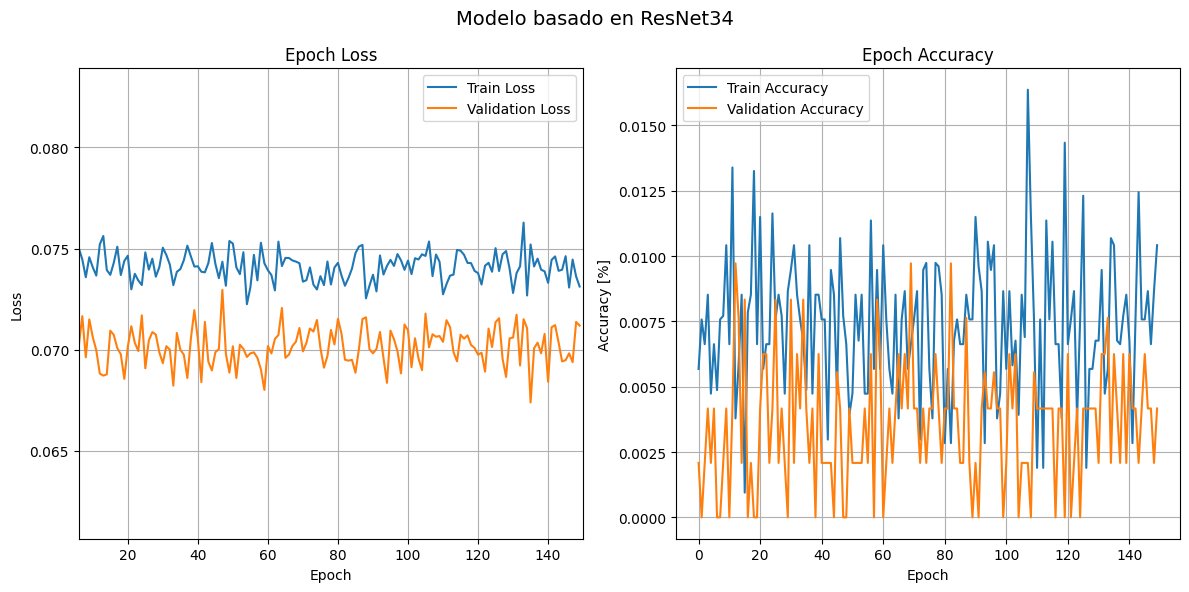

In [29]:
plot_metrics(model_resnet34,title="Modelo basado en ResNet34")

## 3.4 Validación

Se toma una imagen al azar y se visualiza la dirección de la mirada actual VS la predicha
- Flecha azul: indica la posición de la mirada verdadera.
- Flecha verde: indica la posición de la mirada predicha por el modelo.

In [222]:
#Opcional: Cargar modelo de un archivo --------------------------------
# Para probar que se haya guardado bien el mejor modelo entrenado
loaded_model = GazeEstimation_ResNet18() #Cambiar por el modelo a cargar
# loaded_model = CNN_custom() #Cambiar por el modelo a cargar
# loaded_model.load_state_dict(torch.load('./modelos/cnn_propia__lr_dynamic__initk_3x3__less_dropoutd.pth',weights_only=True))
loaded_model.load_state_dict(torch.load('./modelos/resnet18_individual_fc_dropout.pth',weights_only=True))
loaded_model.to(device)
# ----------------------------------------------------------------------

GazeEstimation_ResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Actual: 
	 pitch=-0.390 rad | yaw=-0.067 rad
	 proyección 2D del ángulo: 280.05° deg
Predicted: 
	 pitch=-0.404 rad | yaw=-0.025 rad
	 proyección 2D del ángulo: 273.69° deg
**Preciso (tolerancia = 15°): 1


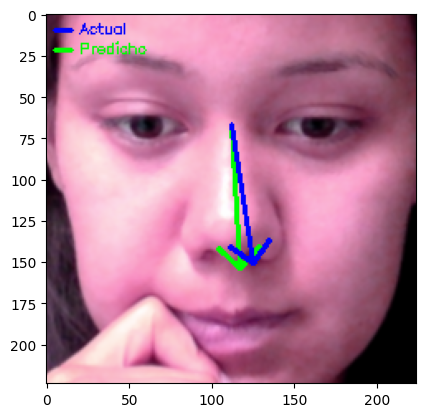

In [271]:

# Se elige el modelo a probar
model = loaded_model

# Se elige imagen al azar y se obtienen sus labesl (pitch,yaw)
img, gaze = train_dataset[randint(0,len(train_dataset)-1)]
pitch = gaze[0]
yaw = gaze[1]
angle = angle_to_2d(np.array([gaze]))

# Ahora se pasa la imagen por el modelo y se obtiene la predicción
predicted_gaze = model(img.unsqueeze(0).to(device))
pitch_predicted = predicted_gaze[0][0].item()
yaw_predicted = predicted_gaze[0][1].item()
img = img.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
predicted_gaze = predicted_gaze.squeeze(0).detach().cpu().numpy()
angle_predicted = angle_to_2d(np.array([predicted_gaze]))

# Se define la tolerancia para considerar una predicción como precisa o no 
tolerancia = 15 # 15° de tolerancia para considerar una predicción como error
accurate = int(is_accurate(angle,angle_predicted,tolerance=tolerancia)[0])

# Impresión de parámetros
print("Actual: ")
print(f"\t pitch={pitch:.3f} rad | yaw={yaw:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle[0]:.2f}° deg")
print("Predicted: ")
print(f"\t pitch={pitch_predicted:.3f} rad | yaw={yaw_predicted:.3f} rad")
print(f"\t proyección 2D del ángulo: {angle_predicted[0]:.2f}° deg")
print(f"**Preciso (tolerancia = {tolerancia}°): {accurate}")

# Se agregan anotaciones a la imagen
img = put_gaze_annotation(img,predicted_gaze,method=1,color=(0,255,0), label="Predicho",label_y=22) #Prediced: flecha verde
img = put_gaze_annotation(img,gaze,method=1,color=(255,0,0),label="Actual",label_y=10) #Actual: flecha azul

# Mostrar imagen (se convierte a RGB porque openCV trabaja en BGR)
plt.imshow(rgb(img))

## 3.5 Visualización de métricas en Tensorboard

In [32]:
%load_ext tensorboard
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 1793849), started 2 days, 9:49:11 ago. (Use '!kill 1793849' to kill it.)

## 4. Ajuste de hiperparámetros

Se busca responder la siguiente consigna del TP: 

> Entrenamientos realizados (al menos 4). Hiperparametros utilizados en cada uno.

- Instanciar el modelo con diferentes nombres asi se guardan distintos modelos en TensorBoard y es más fácil comparar
